# Selección de portafolios usando simulación Montecarlo

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Separation_theorem_of_MPT.svg/2000px-Separation_theorem_of_MPT.svg.png" width="400px" height="400px" />

> Durante el curso, específicamente en los módulos dos y tres, elaboramos toda la fundamentación de la teoría moderna de portafolios de Markowitz. Ésta se basa en la existencia de una línea especial en el espacio de rendimiento esperado vs. volatilidad, llamada **frontera de mínima varianza**.

> Al finalizar el módulo 3, vimos que no importa la cantidad de activos riesgosos que se tengan, si encontramos dos portafolios sobre la frontera eficiente, podemos reconstruirla. Dos portafolios importantes que hallamos en el curso fueron:

> - **Portafolio de mínima varianza**: minimizando la varianza.
> - **Portafolio eficiente en media varianza**: maximizando el radio de Sharpe.

> Por otra parte, resolver problemas de optimización cuando la cantidad de variables crece, se vuelve un problema complejo, computacionalmente hablando. Así que desarrollar métodos alternativos a la optimización que nos permitan encontrar los anteriores portafolios es de gran interés...

## 1. Descargamos activos de la BMV

Por simplicidad, y para entender las ideas alrededor de la selección de portafolios usando simulación montecarlo, utilizaremos únicamente tres activos de la BMV: America Movil SAB de CV L	(AMXL.MX), Walmart de Mexico SAB de CV	(WALMEX.MX) y Fomento Economico Mexicano S.A.B. de C.V.	(FEMSAUBD.MX).

1.1. Descargar precios mensuales ajustados en el cierre para los tres activos mencionados anteriormente en los últimos 5 años:

In [1]:
# Importar librerías
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None, freq='m'):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.YahooDailyReader(symbols=tickers, start=start_date, end=end_date, interval=freq).read()['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [3]:
# Descargar precios y graficar
closes = get_adj_closes(tickers=["AMXL.MX", "WALMEX.MX", "FEMSAUBD.MX"],
                        start_date="2016-01-01")

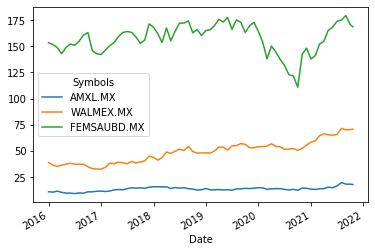

In [4]:
closes.plot();

In [5]:
closes.head()

Symbols,AMXL.MX,WALMEX.MX,FEMSAUBD.MX
Date,,,
2016-01-01,11.013456,38.900986,153.211258
2016-02-01,10.625963,36.443008,151.516983
2016-03-01,11.564561,35.108040,148.743607
2016-04-01,10.470963,36.435287,142.751083
2016-05-01,9.721808,37.268070,148.690094


1.2. A partir de los precios, obtener los rendimientos mensuales:

In [6]:
# Obtener rendimientos mensuales y graficar
ret = closes.pct_change().dropna()

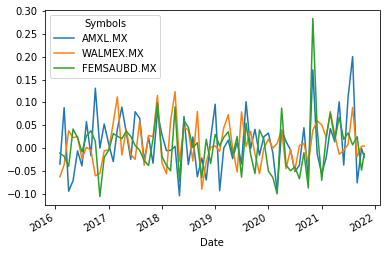

In [7]:
ret.plot();

1.3. Finalmente, a partir de los rendimientos mensuales, estimar la tendencia central de los rendimientos (rendimiento esperado), y caracterizar el riesgo de los activos (varianzas y covarianzas)

In [8]:
# Resumen: rendimiento medio mensual y volatilidad
ret_summary = pd.DataFrame({"Media": ret.mean(),
                            "Vol": ret.std()})
ret_summary

,Media,Vol
Symbols,,
AMXL.MX,0.008779,0.061896
WALMEX.MX,0.009576,0.045582
FEMSAUBD.MX,0.002894,0.057158


In [11]:
# Matriz de covarianza
Sigma = ret.cov()
Sigma

Symbols,AMXL.MX,WALMEX.MX,FEMSAUBD.MX
Symbols,,,
AMXL.MX,0.003831,0.000419,0.001654
WALMEX.MX,0.000419,0.002078,0.000948
FEMSAUBD.MX,0.001654,0.000948,0.003267


In [12]:
# Matriz de correlación
corr = ret.corr()
corr

Symbols,AMXL.MX,WALMEX.MX,FEMSAUBD.MX
Symbols,,,
AMXL.MX,1.000000,0.148482,0.467524
WALMEX.MX,0.148482,1.000000,0.363738
FEMSAUBD.MX,0.467524,0.363738,1.000000


___
## 2. Selección de portafolios mediante montecarlo

Antes de continuar, consultamos la tasa libre de riesgo al día de hoy en [Banxico](http://www.banxico.org.mx/):

In [31]:
# Tasa libre de riesgo
rf = 0.0483 / 12

¿Alguien tiene alguna idea de lo que es simulación montecarlo?

En cuanto a la selección de portafolios, lo que hacemos es simular una gran cantidad de posibles portafolios que se pueden construir con los activos dados (generamos muchas ponderaciones posibles), y calculamos su rendimiento esperado y volatilidad para dibujarlos, y así poder identificar objetos de interés:

- frontera eficiente;
- portafolio de mínima varianza;
- portafolio EMV...

In [32]:
# Definimos el número de portafolios que simularemos, y la cantidad de activos que tenemos
n_port = 100000
n_act = 3

2.1. Generamos los portafolios

In [33]:
# Ayuda en la funcion numpy.random.dirichlet
np.random.dirichlet?

In [34]:
# Generar una matriz de pesos de n_portafolios x n_activos,
# tal que cada fila sume uno (recordar restricción)
W = np.random.dirichlet(alpha=np.ones(n_act), size=n_port)

In [35]:
W.shape

(100000, 3)

In [36]:
W[:5]

array([[0.86084505, 0.1265953 , 0.01255965],
       [0.1500225 , 0.52299016, 0.32698733],
       [0.0292241 , 0.58564536, 0.38513054],
       [0.65582515, 0.09070107, 0.25347379],
       [0.38417133, 0.19473441, 0.42109426]])

In [37]:
W.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [38]:
# Rendimientos y volatilidad de cada portafolios
er = W.dot(ret_summary["Media"])

In [39]:
er.shape

(100000,)

In [40]:
s = np.zeros(n_port)
for i in range(n_port):
    s[i] = (W[i, :].T.dot(Sigma).dot(W[i, :]))**0.5

In [41]:
s.shape

(100000,)

In [42]:
s

array([0.05479922, 0.03944576, 0.0409821 , ..., 0.05270305, 0.04126159,
       0.04180196])

In [43]:
# Radio de Sharpe
rs = (er - rf) / s

In [44]:
# Data frame de resultados
portafolios_montecarlo = pd.DataFrame(
    {
        "w_AMXL": W[:, 0],
        "w2_WALMEX": W[:, 1],
        "w3_FEMSAUBD": W[:, 2],
        "Media": er,
        "Vol": s,
        "RS": rs
    }
)

In [45]:
portafolios_montecarlo.head()

,w_AMXL,w2_WALMEX,w3_FEMSAUBD,Media,Vol,RS
0,0.860845,0.126595,0.012560,0.008806,0.054799,0.087252
1,0.150023,0.522990,0.326987,0.007272,0.039446,0.082308
2,0.029224,0.585645,0.385131,0.006979,0.040982,0.072091
3,0.655825,0.090701,0.253474,0.007360,0.050181,0.066456
4,0.384171,0.194734,0.421094,0.006456,0.044461,0.054681


2.2. Aproximar portafolio de mínima varianza y portafolio eficiente en media varianza

In [47]:
# Portafolio EMV
emv = portafolios_montecarlo.loc[portafolios_montecarlo["RS"].idxmax()]
emv

w_AMXL         0.278668
w2_WALMEX      0.721131
w3_FEMSAUBD    0.000202
Media          0.009353
Vol            0.039330
RS             0.135471
Name: 53436, dtype: float64

In [48]:
# Portafolio mínima varianza
minvar = portafolios_montecarlo.loc[portafolios_montecarlo["Vol"].idxmin()]
minvar

w_AMXL         0.255848
w2_WALMEX      0.591323
w3_FEMSAUBD    0.152829
Media          0.008351
Vol            0.038483
RS             0.112417
Name: 30485, dtype: float64

2.3. Dibujar todos los portafolios en el espacio de rendimiento esperado vs. volatilidad

[0.035, 0.065, 0, 0.012]

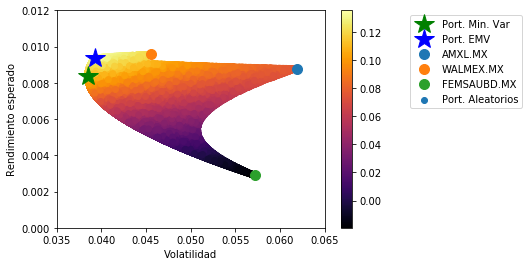

In [52]:
# Gráfica
plt.figure(figsize=(6, 4))
plt.scatter(portafolios_montecarlo["Vol"],
            portafolios_montecarlo["Media"],
            c=portafolios_montecarlo["RS"],
            cmap="inferno", 
            label="Port. Aleatorios")
plt.plot(minvar["Vol"], minvar["Media"], '*g', ms=20, label="Port. Min. Var")
plt.plot(emv["Vol"], emv["Media"], '*b', ms=20, label="Port. EMV")
for ticker in ["AMXL.MX", "WALMEX.MX", "FEMSAUBD.MX"]:
    plt.plot(ret_summary.loc[ticker, "Vol"], ret_summary.loc[ticker, "Media"], 'o', ms=10, label=ticker)
plt.xlabel("Volatilidad")
plt.ylabel("Rendimiento esperado")
plt.colorbar()
plt.legend(loc="upper left", bbox_to_anchor=(1.3, 1))
plt.axis([0.035, 0.065, 0, 0.012])

## 3. Comparar con los resultados obtenidos por optimización

3.1. Portafolio de mínima varianza

In [ ]:
# Importamos funcion minimize del modulo optimize de scipy


In [ ]:
## Construcción de parámetros
# 1. Sigma: matriz de varianza-covarianza

# 2. Eind: rendimientos esperados activos individuales


In [ ]:
# Función objetivo


In [ ]:
# Dato inicial

# Cotas de las variables

# Restricciones


In [ ]:
# Portafolio Min var


In [ ]:
# Comparar


In [53]:
minvar

w_AMXL         0.255848
w2_WALMEX      0.591323
w3_FEMSAUBD    0.152829
Media          0.008351
Vol            0.038483
RS             0.112417
Name: 30485, dtype: float64

3.2. Portafolio EMV

In [ ]:
# Función objetivo


In [ ]:
# Dato inicial

# Cotas de las variables

# Restricciones


In [ ]:
# Portafolio EMV


In [ ]:
# Comparar


In [54]:
emv

w_AMXL         0.278668
w2_WALMEX      0.721131
w3_FEMSAUBD    0.000202
Media          0.009353
Vol            0.039330
RS             0.135471
Name: 53436, dtype: float64

# Conclusión

- Tenemos una herramienta para aproximar toda la teoría de Markowitz.

- Esta herramienta no involucra optimización, solo generar números aleatorios en el símplex unitario.

- Por tanto, no le afecta el problema de dimensión (cuando tenemos muchos activos).

# Anuncios parroquiales

## 1. Fin de módulo. Abrir Clase0 y revisar objetivos del módulo.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>